Project Setup/Env setup

In [ ]:
# install necessary libraries and modules
!pip install requests beautifulsoup4 scrapy pandas sqlalchemy boto3 psycopg2-binary

In [ ]:
!pip install duckdb

In [1]:
# import necessary libraries and modules
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [ ]:
# Testing if request response is 200[ok]
url = 'https://www.amazon.in/s?k=iPhone'
# headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36','Accept-Language': 'en-US, en;q=0.5'}
response = requests.get(url,headers=headers)

response

In [77]:
# DEMO : Amazon scraper testing using a proxy
# Use proxy rotation to avoid getting blocked from target platforms
import requests
from bs4 import BeautifulSoup

def scrape_amazon(keyword):
    url = f'https://www.amazon.in/s?k={keyword}'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36',
        'Accept-Language': 'en-US, en;q=0.5'
    }
    proxies = {
        # 'http': 'http://221.140.235.236:5002',
        'https': 'http://221.140.235.236:5002'
    }

    product_list = []
    
    try:
        response = requests.get(url, headers=headers,proxies = proxies)
        response.raise_for_status()  # Raise HTTPError for bad responses
        soup = BeautifulSoup(response.text, 'html.parser')

        products = soup.find_all('div', {'data-component-type': 's-search-result'})
        
        for product in products:
            product_name_elem = product.find('span', class_='a-size-medium a-color-base a-text-normal')
            product_price_elem = product.find('span', class_='a-offscreen')
            product_link_elem = product.find('a', class_='a-link-normal s-no-outline')

            # Check if product name, price, and link elements exist
            if product_name_elem:
                product_name = product_name_elem.text.strip()
            else:
                product_name = None
            
            if product_price_elem:
                product_price = product_price_elem.text.strip()
            else:
                product_price = None
            
            if product_link_elem:
                product_link = 'https://www.amazon.in' + product_link_elem['href']
            else:
                product_link = None
            
            product_list.append({
                'product_name': product_name,
                'product_price(₹)': product_price,
                'product_link': product_link
            })
            
    except requests.exceptions.HTTPError as err:
        print(f"HTTP error occurred: {err}")
    except Exception as err:
        print(f"An error occurred: {err}")

    return product_list

if __name__ == "__main__":
    # keyword = input("Enter a keyword to search on Amazon: ")
    amazon_data = scrape_amazon('iPhone')
    amazon_df = pd.DataFrame(amazon_data)

HTTP error occurred: 503 Server Error: Service Unavailable for url: https://www.amazon.in/s?k=iPhone


EXTRACTION

Data Extraction from Amazon E-Commerce site

In [ ]:
# proxy rotating function
import random
def get_random_proxy(proxy_file):
    # Read proxy list from file
    with open(proxy_file, 'r') as file:
        proxies = file.readlines()
    # Choose a random proxy
    proxy = random.choice(proxies).strip()
    return {
        'http': f'http://{proxy}',
        'https': f'http://{proxy}',
    }

In [ ]:
# Function to scrape data from amazon website
def scrape_amazon(keyword):
    url = f'https://www.amazon.in/s?k={keyword}'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36','Accept-Language': 'en-US, en;q=0.5'}
    proxies = get_random_proxy("working_proxies.txt")
    product_list = []
    
    try:

        response = requests.get(url, headers=headers, proxies=proxies,timeout = 10)
        response.raise_for_status()  # Raise HTTPError for bad responses
        soup = BeautifulSoup(response.text, 'html.parser')

        products = soup.find_all('div', {'data-component-type': 's-search-result'})
        
        for product in products:
            product_name_elem = product.find('span', class_='a-size-medium a-color-base a-text-normal')
            # product_price_elem = product.find('span', class_='a-price').find('span', class_='a-offscreen')
            product_price_elem = product.find('span', class_='a-offscreen')

            # Check if product name and price elements exist
            if product_name_elem:
                product_name = product_name_elem.text.strip()
            else:
                product_name = None
            
            if product_price_elem:
                # product_price = product_price_elem.text.strip().replace('₹','').replace(',','')
                # try:
                #     product_price = float(product_price)
                #     # product_price = round(product_price,2)
                # except ValueError:
                #     product_price = None
                product_price = product_price_elem.text.strip()
            else:
                product_price = None
            # print(f'Product Name: {product_name}')
            # print(f'Product Price: {product_price}')
            # print()
            product_list.append({
                'product_name':product_name,
                'product_price(₹)':product_price
            })
            
    except requests.exceptions.HTTPError as err:
        print(f"HTTP error occurred: {err}")
    except Exception as err:
        print(f"An error occurred: {err}")

    return product_list
    
if __name__ == "__main__":
    # keyword = input("Enter a keyword to search on Amazon: ")
    amazon_data = scrape_amazon('iPhone')
    amazon_df = pd.DataFrame(amazon_data)

TRANSFORMATION : Data Cleaning

In [33]:
amazon_df.head(20)

,product_name,product_price(₹)
0,iPhone 13 (128GB) - Pink,"₹52,090"
1,iPhone 13 (128GB) - Blue,"₹52,090"
2,iPhone 13 (128GB) - Midnight,"₹52,090"
3,iPhone 13 (128GB) - Green,"₹52,090"
4,iPhone 13 (128GB) - Starlight,"₹52,090"
5,iPhone 15 (128 GB) - Black,"₹73,100"
6,iPhone 14 (128 GB) - Blue,"₹62,800"
7,iPhone 15 (128 GB) - Blue,"₹73,100"
8,iPhone 15 Plus (128 GB) - Black,"₹82,600"
9,iPhone 13 (256GB) - Midnight,"₹61,390"


In [6]:
# Remove '₹' from the product price  
amazon_df['product_price(₹)'] = amazon_df['product_price(₹)'].str.replace('₹','')
# Remove ',' from the product price  
amazon_df['product_price(₹)'] = amazon_df['product_price(₹)'].str.replace(',','')
amazon_df.head()

,product_name,product_price(₹)
0,Apple iPhone 15 (128 GB) - Black,71499
1,Apple iPhone 15 Pro (128 GB) - Natural Titanium,127990
2,Apple iPhone 13 (128GB) - Starlight,48999
3,Apple iPhone 15 (128 GB) - Black,71499
4,Apple iPhone 13 (128GB) - Pink,48999


In [7]:
# Change price's datatype from string to numeric
# df['Column2'] = pd.to_numeric(df['Column2'], errors='coerce')
amazon_df['product_price(₹)'] = pd.to_numeric(amazon_df['product_price(₹)'],errors='coerce')

In [8]:
# Change price's datatype into specific type (here: float)
amazon_df['product_price(₹)'] = amazon_df['product_price(₹)'].astype(float)
amazon_df.iloc[8:13]

,product_name,product_price(₹)
8,Apple iPhone 13 (128GB) - Green,48999.0
9,Apple iPhone 14 (128 GB) - Blue,62800.0
10,Apple iPhone 15 Plus (128 GB) - Black,80999.0
11,Apple iPhone 14 (128 GB) - Starlight,NaN
12,5s Gold (16GB Storage with 1-Year Warranty) Or...,NaN


In [9]:
amazon_df.dtypes

product_name         object
product_price(₹)    float64
dtype: object

In [10]:
# Check if there is any null values in the dataset
s=amazon_df.isna()
print(s)

    product_name  product_price(₹)
0          False             False
1          False             False
2          False             False
3          False             False
4          False             False
5          False             False
6          False             False
7          False             False
8          False             False
9          False             False
10         False             False
11         False              True
12         False              True
13         False             False
14         False             False
15         False             False
16         False             False
17         False             False


In [50]:
# Function to replace 'NaN' with '0' if exists

def replaceNan(df):
    if df.isna().sum().sum()>0:
        df = df.fillna(0)
    return df

# Apply the function to replace NaN or None values with 0
replaceNan(amazon_df)
amazon_df.head(20)

,product_name,product_price(₹)
0,Apple iPhone 15 (128 GB) - Black,71499.0
1,Apple iPhone 15 Pro (128 GB) - Natural Titanium,127990.0
2,Apple iPhone 13 (128GB) - Starlight,48999.0
3,Apple iPhone 15 (128 GB) - Black,71499.0
4,Apple iPhone 13 (128GB) - Pink,48999.0
5,Apple iPhone 15 (128 GB) - Blue,71499.0
6,Apple iPhone 13 (128GB) - Midnight,49499.0
7,Apple iPhone 13 (128GB) - Blue,48799.0
8,Apple iPhone 13 (128GB) - Green,48999.0
9,Apple iPhone 14 (128 GB) - Blue,62800.0


In [51]:
# Save the DataFrame to a CSV file (Optional)
amazon_df.to_csv('amazon_products_data.csv', index=False, encoding = 'utf-8')

Data Extraction from Flipkart E-Commerce site

In [52]:
# Function to scrape data from Flipkart website
def scrape_flipkart(key):
    url = f'https://www.flipkart.com/search?q={key}'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36','Accept-Language': 'en-US, en;q=0.5'}
    proxies = get_random_proxy("working_proxies.txt")
    product_list = []
    
    try:
        response = requests.get(url, headers=headers, proxies=proxies,timeout = 10)
        soup = BeautifulSoup(response.content, "html.parser")
    
        # products = soup.find_all('div', class_="cPHDOP col-12-12")
        products = soup.find_all('div', class_="yKfJKb row")
    
        for product in products:
            product_name_elem = product.find('div', class_="KzDlHZ")
            product_price_elem = product.find('div',class_="Nx9bqj _4b5DiR")

            if product_name_elem:
                product_name = product_name_elem.text.strip()
            else:
                product_name = None
            
            if product_price_elem:
                product_price = product_price_elem.text.strip()
                # product_price = product_price_elem.text.strip().replace('₹','').replace(',','')
                # try:
                #     product_price = float(product_price)
                # except ValueError:
                #     product_price = None
            else:
                product_price = None
                
            # print(f'Product name : {product_name}')
            # print(f'product_price : {product_price}')
            # print()
            product_list.append({
                'product_name':product_name,
                'product_price(₹)':product_price
            })
    except requests.exceptions.HTTPError as err:
        print(f"HTTP error occurred: {err}")
    except Exception as err:
        print(f"An error occurred: {err}")

    return product_list

if __name__ == "__main__":
    flipkart_data = scrape_flipkart('iPhone')
    flipkart_df = pd.DataFrame(flipkart_data)

TRANSFORMATION : Data Cleaning

In [53]:
flipkart_df.head()

,product_name,product_price(₹)
0,"Apple iPhone 14 Plus (Blue, 128 GB)","₹58,999"
1,"Apple iPhone 15 (Pink, 128 GB)","₹69,999"
2,"Apple iPhone 14 Plus (Starlight, 128 GB)","₹58,999"
3,"Apple iPhone 14 Plus (Purple, 128 GB)","₹58,999"
4,"Apple iPhone 14 Plus (Midnight, 128 GB)","₹58,999"


In [54]:
# Remove '₹' from the product price
flipkart_df['product_price(₹)'] = flipkart_df['product_price(₹)'].str.replace('₹','')
# Remove ',' from the product price
flipkart_df['product_price(₹)'] = flipkart_df['product_price(₹)'].str.replace(',','')
flipkart_df.head()

,product_name,product_price(₹)
0,"Apple iPhone 14 Plus (Blue, 128 GB)",58999
1,"Apple iPhone 15 (Pink, 128 GB)",69999
2,"Apple iPhone 14 Plus (Starlight, 128 GB)",58999
3,"Apple iPhone 14 Plus (Purple, 128 GB)",58999
4,"Apple iPhone 14 Plus (Midnight, 128 GB)",58999


In [55]:
# Transform product price datatype into numeric
# amazon_df['product_price(₹)'] = pd.to_numeric(amazon_df['product_price(₹)'],errors='coerce')
flipkart_df['product_price(₹)'] = pd.to_numeric(flipkart_df['product_price(₹)'],errors = 'coerce')

In [56]:
# Transform product price datatype into nspecific datatype(here : float)
flipkart_df['product_price(₹)'] = flipkart_df['product_price(₹)'].astype(float)

In [57]:
flipkart_df.head(30)

,product_name,product_price(₹)
0,"Apple iPhone 14 Plus (Blue, 128 GB)",58999.0
1,"Apple iPhone 15 (Pink, 128 GB)",69999.0
2,"Apple iPhone 14 Plus (Starlight, 128 GB)",58999.0
3,"Apple iPhone 14 Plus (Purple, 128 GB)",58999.0
4,"Apple iPhone 14 Plus (Midnight, 128 GB)",58999.0
5,"Apple iPhone 15 (Blue, 128 GB)",64999.0
6,"Apple iPhone 14 Plus (Yellow, 128 GB)",58999.0
7,"Apple iPhone 15 (Green, 128 GB)",64999.0
8,"Apple iPhone 15 (Black, 128 GB)",66999.0
9,"Apple iPhone 14 (Blue, 128 GB)",56999.0


In [58]:
flipkart_df.dtypes

product_name         object
product_price(₹)    float64
dtype: object

In [59]:
# Check if there is null values
flipkart_df.isna()

,product_name,product_price(₹)
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
5,False,False
6,False,False
7,False,False
8,False,False
9,False,False


In [60]:
# Invoke 'replaceNan' function to replace 'NaN' with '0' if exists
replaceNan(flipkart_df)

,product_name,product_price(₹)
0,"Apple iPhone 14 Plus (Blue, 128 GB)",58999.0
1,"Apple iPhone 15 (Pink, 128 GB)",69999.0
2,"Apple iPhone 14 Plus (Starlight, 128 GB)",58999.0
3,"Apple iPhone 14 Plus (Purple, 128 GB)",58999.0
4,"Apple iPhone 14 Plus (Midnight, 128 GB)",58999.0
5,"Apple iPhone 15 (Blue, 128 GB)",64999.0
6,"Apple iPhone 14 Plus (Yellow, 128 GB)",58999.0
7,"Apple iPhone 15 (Green, 128 GB)",64999.0
8,"Apple iPhone 15 (Black, 128 GB)",66999.0
9,"Apple iPhone 14 (Blue, 128 GB)",56999.0


In [61]:
# Saving the DataFrame as CSV file
flipkart_df.to_csv('flipkart_products_data.csv',index=False)

LOADING

Loading data into AWS RDS-PostgreSQL database

In [3]:
# Read cleaned amazon data
cleaned_amazon_data = pd.read_csv('amazon_products_data.csv')
cleaned_amazon_data

,product_name,product_price(₹)
0,Apple iPhone 15 (128 GB) - Black,71499
1,Apple iPhone 15 Pro (128 GB) - Natural Titanium,127990
2,Apple iPhone 13 (128GB) - Starlight,48999
3,Apple iPhone 15 (128 GB) - Black,71499
4,Apple iPhone 13 (128GB) - Pink,48999
5,Apple iPhone 15 (128 GB) - Blue,71499
6,Apple iPhone 13 (128GB) - Midnight,49499
7,Apple iPhone 13 (128GB) - Blue,48799
8,Apple iPhone 13 (128GB) - Green,48999
9,Apple iPhone 14 (128 GB) - Blue,62800


# 

In [4]:
# Read cleaned flipkart data
cleaned_flipkart_data = pd.read_csv('flipkart_products_data.csv')
cleaned_flipkart_data

,product_name,product_price(₹)
0,"Apple iPhone 14 Plus (Blue, 128 GB)",58999.0
1,"Apple iPhone 15 (Pink, 128 GB)",69999.0
2,"Apple iPhone 14 Plus (Starlight, 128 GB)",58999.0
3,"Apple iPhone 14 Plus (Purple, 128 GB)",58999.0
4,"Apple iPhone 14 Plus (Midnight, 128 GB)",58999.0
5,"Apple iPhone 15 (Blue, 128 GB)",64999.0
6,"Apple iPhone 14 Plus (Yellow, 128 GB)",58999.0
7,"Apple iPhone 15 (Green, 128 GB)",64999.0
8,"Apple iPhone 15 (Black, 128 GB)",66999.0
9,"Apple iPhone 14 (Blue, 128 GB)",56999.0


Use PGADMIN to connect PostgreSQL database instance hosted on AWS to create Database schema and required tables.

In [5]:
# db connection

import psycopg2
from psycopg2 import sql

# Database connection parameters
db_params = {
    'dbname': 'initial_db2',
    'user': 'postgres',
    'password': 'Qwerty123',
    'host': 'database-1.cjoos8c8s356.us-east-1.rds.amazonaws.com',
    'port': '5432'
}

# Connect to the database
conn = psycopg2.connect(**db_params)
cursor = conn.cursor()


In [6]:
# Execute a simple query to check the connection
cursor.execute("SELECT 1")
    
# Fetch one result
result = cursor.fetchone()
print(result)

(1,)


In [107]:
# Function to insert data into the specified table
def insert_products_data(cursor, table_name, data_frame):
    insert_query = sql.SQL("""
        INSERT INTO {} (product_name, product_price)
        VALUES (%s, %s)
    """).format(sql.Identifier(table_name))

    for index, row in data_frame.iterrows():
        product_name = row['product_name']
        product_price = row['product_price(₹)']

        cursor.execute(insert_query, (product_name, product_price))

# Insert data into amazon_products table
insert_products_data(cursor, 'amazon_products', cleaned_amazon_data)

# Insert data into flipkart_products table
insert_products_data(cursor, 'flipkart_products', cleaned_flipkart_data)

# Commit the transaction
conn.commit()

# Close the connection
cursor.close()
conn.close()

In [6]:
# Data merged and inserted into combined_data table successfully. [X]
import pandas as pd
from sqlalchemy import create_engine, text

# Database connection parameters
db_params = {
    'dbname': 'initial_db2',
    'user': 'postgres',
    'password': 'Qwerty123',
    'host': 'database-1.cjoos8c8s356.us-east-1.rds.amazonaws.com',
    'port': '5432'
}

# Create the connection
engine = create_engine(f"postgresql://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['dbname']}")

# Fetch data from Amazon and Flipkart tables
amazon_query = "SELECT * FROM amazon_products"
flipkart_query = "SELECT * FROM flipkart_products"

amazon_df = pd.read_sql(amazon_query, engine)
flipkart_df = pd.read_sql(flipkart_query, engine)

# Merge data based on product name, assuming a simple join on product names for simplicity
# You might need a more sophisticated join depending on the product naming conventions
merged_df = pd.merge(amazon_df, flipkart_df, left_on='product_name', right_on='product_name', suffixes=('_amazon', '_flipkart'))

# Create a new dataframe with the desired columns
combined_data_df = merged_df[['product_name', 'product_price_amazon', 'product_name', 'product_price_flipkart']]
combined_data_df.columns = ['amazon_product_name', 'amazon_product_price', 'flipkart_product_name', 'flipkart_product_price']

# Insert the combined data into the combined_data table
combined_data_df.to_sql('combined_data', engine, if_exists='append', index=False)

print("Data merged and inserted into combined_data table successfully.")


Data merged and inserted into combined_data table successfully.


VISUALIZATIONS

These visualizations are also done in Microsoft Power BI

In [10]:
# install necessary libraries for visualization
!pip install matplotlib
!pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ----- --------------------------------- 41.0/294.9 kB 653.6 kB/s eta 0:00:01
   -------------------------------------- - 286.7/294.9 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 2.6 MB/s eta 0:00:00


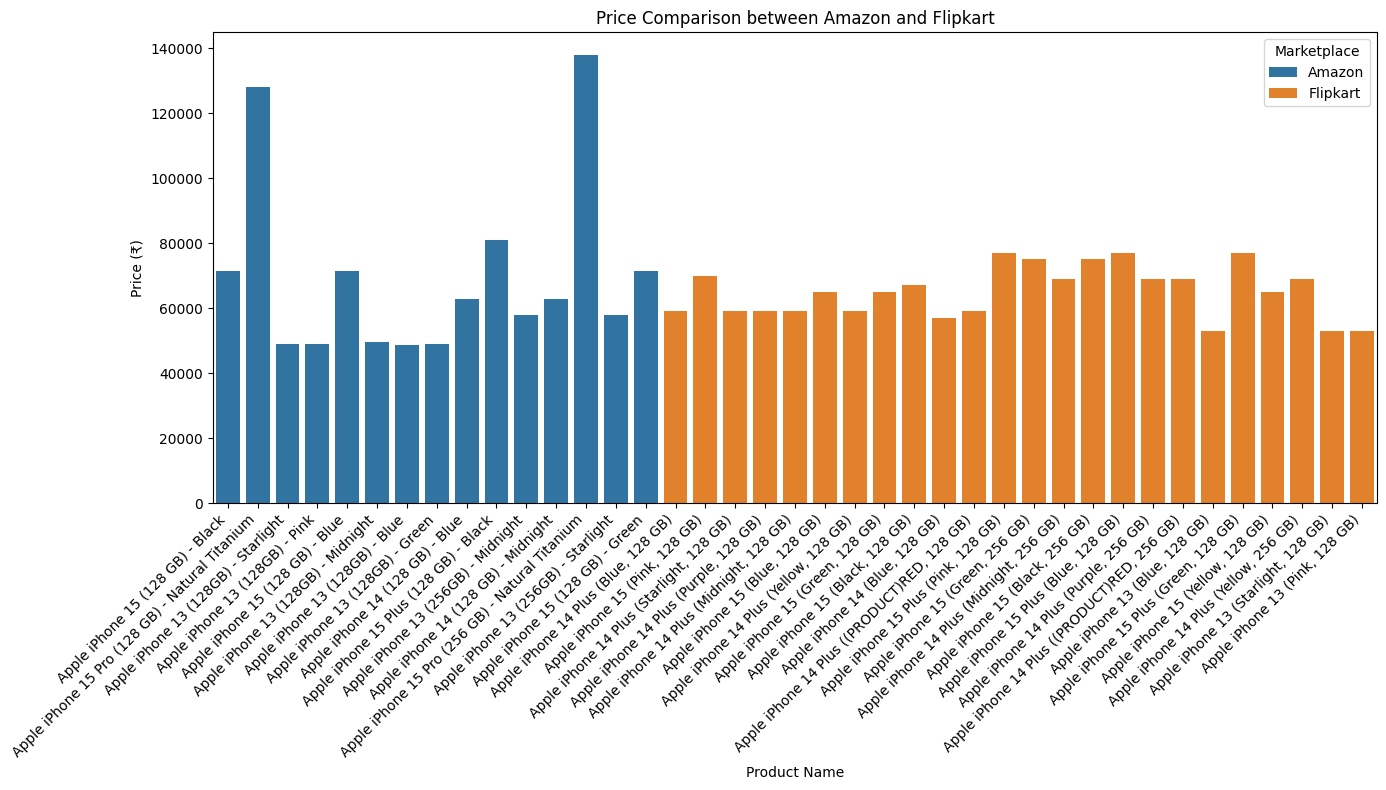

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# Database connection parameters
db_params = {
    'dbname': 'initial_db2',
    'user': 'postgres',
    'password': 'Qwerty123',
    'host': 'database-1.cjoos8c8s356.us-east-1.rds.amazonaws.com',
    'port': '5432'
}

# Create the connection
engine = create_engine(f"postgresql://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['dbname']}")

# Load data into a pandas DataFrame
query = 'SELECT amazon_product_name, amazon_product_price, flipkart_product_name, flipkart_product_price FROM combined_products'
cp_df = pd.read_sql(query, engine)

# Reshape the data for better plotting
df_melted = pd.DataFrame({
    'product_name': cp_df['amazon_product_name'].tolist() + cp_df['flipkart_product_name'].tolist(),
    'product_price': cp_df['amazon_product_price'].tolist() + cp_df['flipkart_product_price'].tolist(),
    'marketplace': ['Amazon'] * len(cp_df) + ['Flipkart'] * len(cp_df)
})

# Example visualization: Price comparison
plt.figure(figsize=(14, 8))
sns.barplot(x='product_name', y='product_price', hue='marketplace', data=df_melted)
plt.xlabel('Product Name')
plt.ylabel('Price (₹)')
plt.title('Price Comparison between Amazon and Flipkart')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Marketplace')
plt.tight_layout()
plt.show()


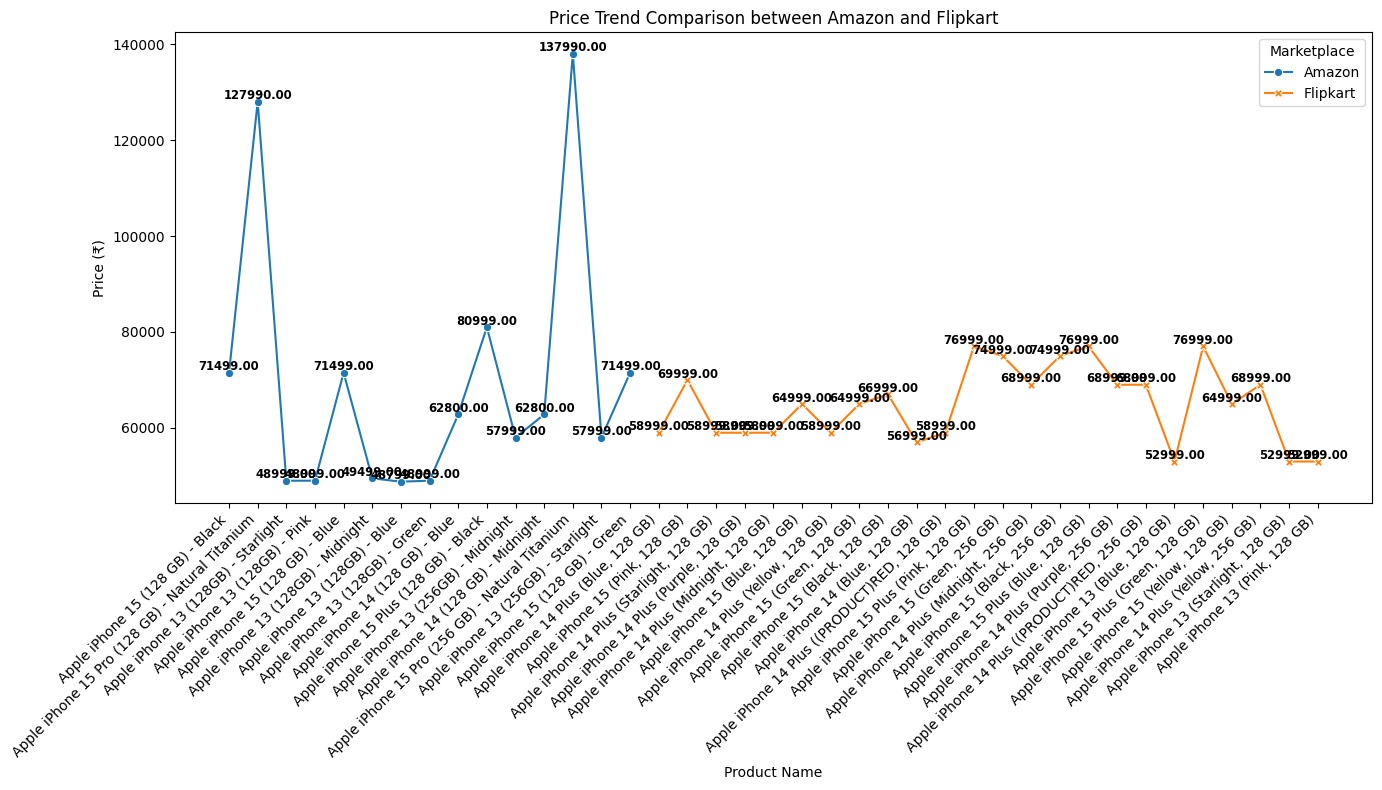

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# Database connection parameters
db_params = {
    'dbname': 'initial_db2',
    'user': 'postgres',
    'password': 'Qwerty123',
    'host': 'database-1.cjoos8c8s356.us-east-1.rds.amazonaws.com',
    'port': '5432'
}

# Create the connection
engine = create_engine(f"postgresql://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['dbname']}")

# Load data into a pandas DataFrame
query = 'SELECT amazon_product_name, amazon_product_price, flipkart_product_name, flipkart_product_price FROM combined_products'
cp_df = pd.read_sql(query, engine)

# Reshape the data for better plotting
df_amazon = cp_df[['amazon_product_name', 'amazon_product_price']].rename(columns={'amazon_product_name': 'product_name', 'amazon_product_price': 'product_price'})
df_amazon['marketplace'] = 'Amazon'

df_flipkart = cp_df[['flipkart_product_name', 'flipkart_product_price']].rename(columns={'flipkart_product_name': 'product_name', 'flipkart_product_price': 'product_price'})
df_flipkart['marketplace'] = 'Flipkart'

# Combine the two dataframes
df_combined = pd.concat([df_amazon, df_flipkart])

# Drop duplicates to ensure same product names are compared
df_combined = df_combined.drop_duplicates(subset=['product_name', 'marketplace'])

# Example visualization: Price trend comparison
plt.figure(figsize=(14, 8))

sns.lineplot(x='product_name', y='product_price', hue='marketplace', data=df_combined, marker='o', style='marketplace', markers=True, dashes=False)

# Add annotations to highlight increments and decrements
for i in range(len(df_combined)):
    plt.text(i, df_combined['product_price'].iloc[i] + 500, f"{df_combined['product_price'].iloc[i]:.2f}", 
             horizontalalignment='center', size='small', color='black', weight='semibold')

plt.xlabel('Product Name')
plt.ylabel('Price (₹)')
plt.title('Price Trend Comparison between Amazon and Flipkart')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Marketplace')
plt.tight_layout()
plt.show()


In [ ]:
# comparision of an item on both platform(easy to understand for customer or any user)
# 3 more graphs for specific item comparison

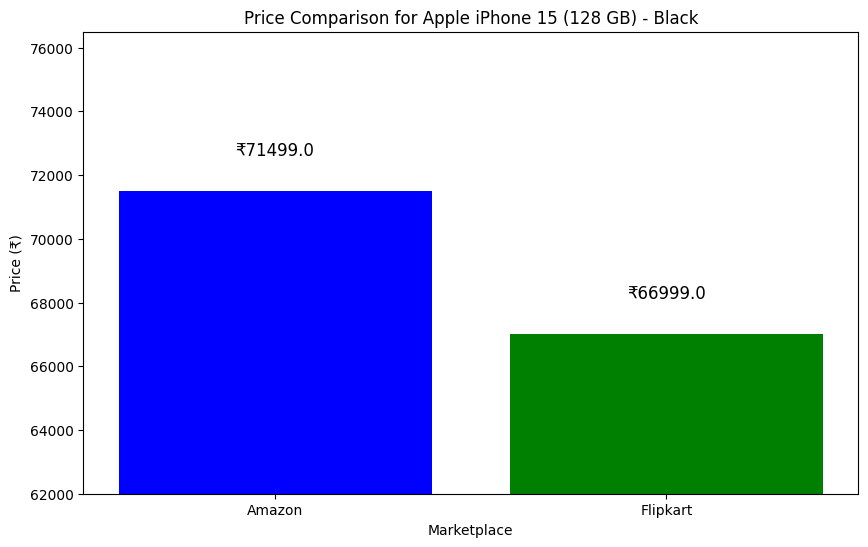

In [19]:
# Compare and visualize certain product from both marketplace
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# Database connection parameters
db_params = {
    'dbname': 'initial_db2',
    'user': 'postgres',
    'password': 'Qwerty123',
    'host': 'database-1.cjoos8c8s356.us-east-1.rds.amazonaws.com',
    'port': '5432'
}

# Create the connection
engine = create_engine(f"postgresql://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['dbname']}")


query = """
SELECT 
    a.product_name AS amazon_product_name, 
    a.product_price AS amazon_product_price,
    f.product_name AS flipkart_product_name,
    f.product_price AS flipkart_product_price,
    CASE
        WHEN a.product_price < f.product_price THEN 'Amazon is cheaper'
        WHEN a.product_price > f.product_price THEN 'Flipkart is cheaper'
        ELSE 'Prices are equal'
    END AS price_comparison
FROM 
    amazon_products a
JOIN 
    flipkart_products f
ON 
    a.product_name = 'Apple iPhone 15 (128 GB) - Black'
AND 
    f.product_name = 'Apple iPhone 15 (Black, 128 GB)'
LIMIT 1;
"""

# Load data into a pandas DataFrame
df_compare = pd.read_sql(query, engine)

# Display the comparison
# print(df_compare)


# Visualization
plt.figure(figsize=(10, 6))
product_names = ['Amazon', 'Flipkart']
product_prices = [df_compare['amazon_product_price'][0], df_compare['flipkart_product_price'][0]]

plt.bar(product_names, product_prices, color=['blue', 'green'])
plt.xlabel('Marketplace')
plt.ylabel('Price (₹)')
plt.title(f"Price Comparison for {df_compare['amazon_product_name'][0]}")
plt.ylim(min(product_prices) - 5000, max(product_prices) + 5000)

# Annotate the bars with the price values
for i, price in enumerate(product_prices):
    plt.text(i, price + 1000, f'₹{price}', ha='center', va='bottom', fontsize=12)

plt.show()


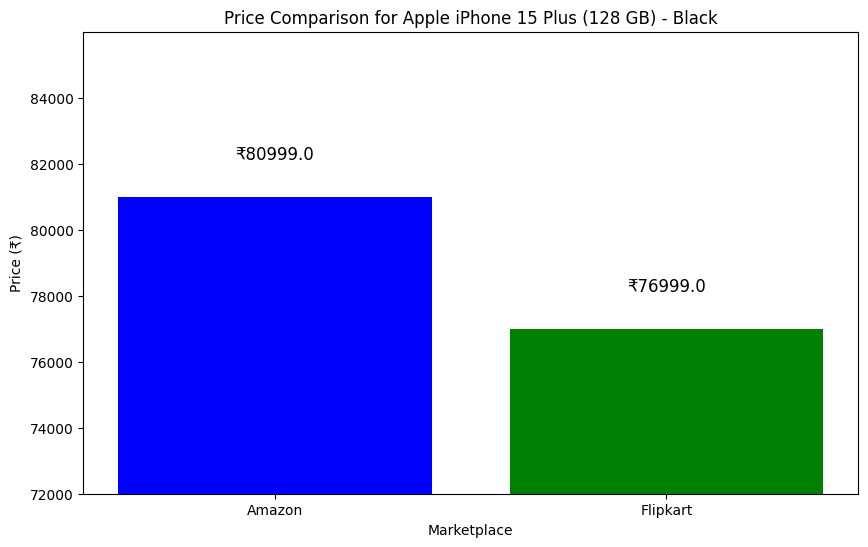

In [18]:
# Compare and visualize certain product from both marketplace
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# Database connection parameters
db_params = {
    'dbname': 'initial_db2',
    'user': 'postgres',
    'password': 'Qwerty123',
    'host': 'database-1.cjoos8c8s356.us-east-1.rds.amazonaws.com',
    'port': '5432'
}

# Create the connection
engine = create_engine(f"postgresql://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['dbname']}")


query = """
SELECT 
    a.product_name AS amazon_product_name, 
    a.product_price AS amazon_product_price,
    f.product_name AS flipkart_product_name,
    f.product_price AS flipkart_product_price,
    CASE
        WHEN a.product_price < f.product_price THEN 'Amazon is cheaper'
        WHEN a.product_price > f.product_price THEN 'Flipkart is cheaper'
        ELSE 'Prices are equal'
    END AS price_comparison
FROM 
    amazon_products a
JOIN 
    flipkart_products f
ON 
    a.product_name = 'Apple iPhone 15 Plus (128 GB) - Black'
AND 
    f.product_name = 'Apple iPhone 15 Plus (Blue, 128 GB)'
LIMIT 1;
"""

# Load data into a pandas DataFrame
df_compare1 = pd.read_sql(query, engine)

# Display the comparison
# print(df_compare)


# Visualization
plt.figure(figsize=(10, 6))
product_names = ['Amazon', 'Flipkart']
product_prices = [df_compare1['amazon_product_price'][0], df_compare1['flipkart_product_price'][0]]

plt.bar(product_names, product_prices, color=['blue', 'green'])
plt.xlabel('Marketplace')
plt.ylabel('Price (₹)')
plt.title(f"Price Comparison for {df_compare1['amazon_product_name'][0]}")
plt.ylim(min(product_prices) - 5000, max(product_prices) + 5000)

# Annotate the bars with the price values
for i, price in enumerate(product_prices):
    plt.text(i, price + 1000, f'₹{price}', ha='center', va='bottom', fontsize=12)

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# Database connection parameters
db_params = {
    'dbname': 'initial_db2',
    'user': 'postgres',
    'password': 'Qwerty123',
    'host': 'database-1.cjoos8c8s356.us-east-1.rds.amazonaws.com',
    'port': '5432'
}

# Create the connection
engine = create_engine(f"postgresql://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['dbname']}")


# Query to count products on Amazon and Flipkart
query = """
SELECT 'Amazon' AS platform, COUNT(*) AS product_count FROM amazon_products
UNION ALL
SELECT 'Flipkart' AS platform, COUNT(*) AS product_count FROM flipkart_products;
"""

# Load data into a DataFrame
df = pd.read_sql(query, engine)

# Extract platform names and product counts
platforms = df['platform']
product_counts = df['product_count']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(product_counts, labels=platforms, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Market Share between Flipkart and Amazon')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.show()
